# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation.

In [0]:
from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [0]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image,gaussFilter)
filterResponseSobelX = signal.convolve2d(image,sobelX)
filterResponseSobelY = signal.convolve2d(image, sobelY)

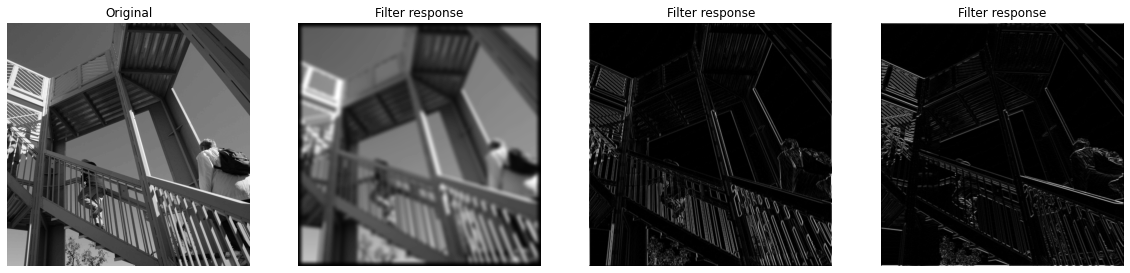

In [0]:
# Show filter responses
import matplotlib.pyplot as plt
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

Answer: In The gaussian filter reduced the noise in the image by blurring it. Sobel filter tried to capture the edges of the image using different weights sobelX and sobelY

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

Answer:
The size of the original image is (512,512)


The image has 1 channel

Color image normally will have 3 channels. 

Question 3: What is the size of the different filters?

Answer: 
Gauss filter: size=(15, 15)
 SobelX, SobelY: size=(3,3)

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?

Answer: If 'same'is used for mode, the output will have same size with resepect to the original image. 

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

Answer: The filter and image do not need to be equally large, 'valid' will remove pixels in each dimension in the filter output, if filter is 3 x 3, we loose 1 pixel on each side in each dimension, so the filter response will be 511 x 511, if the filter is 15 x 15 the filter response is 505 x 505



Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?

Answer: Using mode='valid', we loose some pixels in every convolution as it won't consider 0s. And as we progress, we run out of pixels quickly. 

[Previous answer(for reference): In CNNs, most of the times we use ReLU activation function. This function turns all the negative values of filter or image to 0. When mode ='valid', it won't consider the 0s. So, a lot of information cannot be captured.]  

In [0]:
# Your code for checking sizes of image and filter responses
image.size # image size
image.shape # image shape
gaussFilter.shape #gauss filter shape
gaussFilter.size #gauss filter size
sobelX.size # sobelX filter size
sobelY.shape # sobelY filter shape
temp1 = signal.convolve2d(image,gaussFilter, mode='same') # mode = 'same'
temp1.size # size of output for mode = 'same'
temp2 = signal.convolve2d(image,sobelX, mode='valid') # model = 'valid'
temp2.size #size of output for mode = 'valid'

260100

##  Part 3: Get a graphics card

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [0]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

Using TensorFlow backend.


##  Part 4: How fast is the graphics card?

Lets investigate how much faster a convolution is with the graphics card

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ? 

Answer: To make sure we take the channel of the colors, we take a 3D filter. The 3 represents the channel of the filter

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

Answer:Conv2D calculates the dot product of Image pixel value and weight of the filter. signal.convolve2d will join two 2D arrays by determining mode and boundary conditions where as Conv2D adds a kernel to the model which is convolved with input layers. Conv2D is almost performing 3D convolution operation as it combines all the input channels. 

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?

Answer: GPU is 5 times faster


Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.

Answer: For a batch of 2 images, GPU is 2x faster than CPU. With batch size of 100 there was a necessity to parallelizing the process and GPUs are good to run parallel processes smoothly while CPU cannot be as efficient as GPU. So, there was a big difference. Whereas with batch of 2 imges, the number of parallel processes are very low and CPU is efficient enough to run it however GPU will run it much faster(2x times). 

In [0]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 2

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.10554424100064352
GPU (s):
0.04382862100010243
GPU speedup over CPU: 2x


##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [0]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

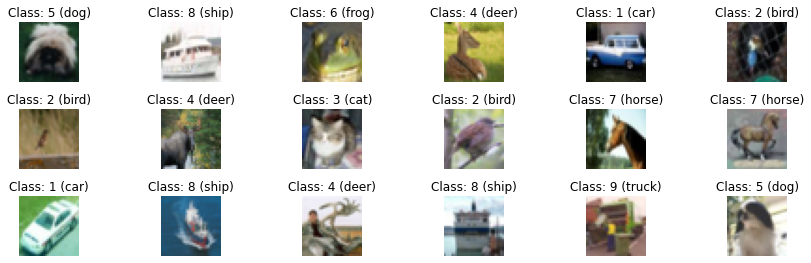

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [0]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,Ytrain,Yval = train_test_split(Xtrain,Ytrain, test_size=0.25)

# Print the size of training data, validation data and test data
print('The size of training data is:{} and training labels is:{}'.format(Xtrain.shape,Ytrain.shape))
print('The size of validation data is:{} and validation labels is:{}'.format(Xval.shape,Yval.shape))
print('The size of test data is:{}and test labels is:{}'.format(Xtest.shape,Ytest.shape))

The size of training data is:(7500, 32, 32, 3) and training labels is:(7500, 1)
The size of validation data is:(2500, 32, 32, 3) and validation labels is:(2500, 1)
The size of test data is:(2000, 32, 32, 3)and test labels is:(2000, 1)


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [0]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/utils/#to_categorical

In [0]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print('==Before Conversion==')
print('The shape of Ytrain = {}'.format(Ytrain.shape))
print('The shape of Yval = {}'.format(Yval.shape))
print('The shape of Ytest = {}'.format(Ytest.shape))

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain = to_categorical(Ytrain)
Yval = to_categorical(Yval)
Ytest = to_categorical(Ytest)

# Print shapes after converting the labels
print('\n==After Conversion==')
print('The shape of Ytrain = {}'.format(Ytrain.shape))
print('The shape of Yval = {}'.format(Yval.shape))
print('The shape of Ytest = {}'.format(Ytest.shape))


==Before Conversion==
The shape of Ytrain = (7500, 1)
The shape of Yval = (2500, 1)
The shape of Ytest = (2000, 1)

==After Conversion==
The shape of Ytrain = (7500, 10)
The shape of Yval = (2500, 10)
The shape of Ytest = (2000, 10)



##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy as CC

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):

    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):
      model.add(Conv2D(filters=n_filters*(2**(i+1)), kernel_size=(3,3), padding='same', activation='relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2,2)))    
    # Add flatten layer
    model.add(Flatten())
    # Add intermediate dense layers
    for i in range(n_dense_layers):
        model.add(Dense(n_nodes, activation='relu'))
        # model.add(BatchNormalization())
        if use_dropout:
            model.add(Dropout(0.5))

        model.add(BatchNormalization())
    # Add final dense layer
    model.add(Dense(10,activation='softmax'))
    # Compile model
    model.compile(loss=CC, optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [0]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

## 2 convolutional layers, no intermediate dense layers

In [0]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model1 = build_CNN(input_shape=input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history1 = model1.fit(x=Xtrain, y=Ytrain, batch_size=batch_size, epochs=epochs,verbose=1, validation_data=(Xval,Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 1s 170us/step - loss: 2.8379 - accuracy: 0.3260 - val_loss: 2.1515 - val_accuracy: 0.2788
Epoch 2/20
7500/7500 [==============================] - 1s 89us/step - loss: 1.6244 - accuracy: 0.4783 - val_loss: 1.7776 - val_accuracy: 0.3432
Epoch 3/20
7500/7500 [==============================] - 1s 90us/step - loss: 1.2510 - accuracy: 0.5700 - val_loss: 1.5497 - val_accuracy: 0.4392
Epoch 4/20
7500/7500 [==============================] - 1s 91us/step - loss: 1.0816 - accuracy: 0.6160 - val_loss: 1.4881 - val_accuracy: 0.4784
Epoch 5/20
7500/7500 [==============================] - 1s 89us/step - loss: 0.9813 - accuracy: 0.6577 - val_loss: 1.4528 - val_accuracy: 0.4984
Epoch 6/20
7500/7500 [==============================] - 1s 91us/step - loss: 0.8932 - accuracy: 0.6856 - val_loss: 1.3377 - val_accuracy: 0.5304
Epoch 7/20
7500/7500 [==============================] - 1s 93us/step - loss: 0.82

In [0]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest,Ytest,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 45us/step
Test loss: 2.7615
Test accuracy: 0.5630


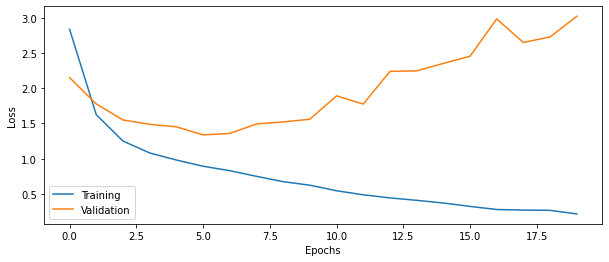

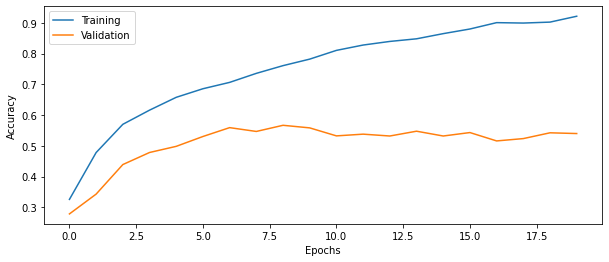

In [0]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance
Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 

Question 11: How big is the difference between training and test accuracy?

Answer: From the results, it can be observed that the test accuracy is much lower than training accuracy. There is a performance difference of 38%(around 90% for training accuracy and 53% for test accuracy). This means that the model is overfitted with training data where it couldn't perform well in capturing the test data.  

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training. 

Answer: 11022MiB of GPU memory is used and GPU is 51% busy

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

Answer: In DNN lab, we are dealing with data where each training data point has 92 dimensions. Here we are using images as data points and each image has 32x32x3 = 3072 dimensions. So, it wiser to use smaller batch size. 

[Previous answer(for reference):Ideal batch size should make one batch worth training data fit into GPU memrory easily. In DNN, the dataset is text and a batch size of 10,000 can make one batch worth data whereas here, we have images and 100 would be large of one batch of data.  

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [0]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model2 = build_CNN(input_shape=input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history2 = model2.fit(x=Xtrain, y=Ytrain, batch_size=batch_size, epochs=epochs,verbose=1, validation_data=(Xval,Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 1s 162us/step - loss: 1.6350 - accuracy: 0.4079 - val_loss: 2.2361 - val_accuracy: 0.2408
Epoch 2/20
7500/7500 [==============================] - 1s 101us/step - loss: 1.2690 - accuracy: 0.5441 - val_loss: 1.7872 - val_accuracy: 0.3680
Epoch 3/20
7500/7500 [==============================] - 1s 101us/step - loss: 1.0726 - accuracy: 0.6117 - val_loss: 1.7185 - val_accuracy: 0.4172
Epoch 4/20
7500/7500 [==============================] - 1s 100us/step - loss: 0.8833 - accuracy: 0.6905 - val_loss: 1.7514 - val_accuracy: 0.4348
Epoch 5/20
7500/7500 [==============================] - 1s 101us/step - loss: 0.7278 - accuracy: 0.7419 - val_loss: 1.4962 - val_accuracy: 0.5304
Epoch 6/20
7500/7500 [==============================] - 1s 101us/step - loss: 0.5384 - accuracy: 0.8143 - val_loss: 1.6278 - val_accuracy: 0.5436
Epoch 7/20
7500/7500 [==============================] - 1s 102us/step - loss

In [0]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest,Ytest,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 47us/step
Test loss: 3.0090
Test accuracy: 0.5330


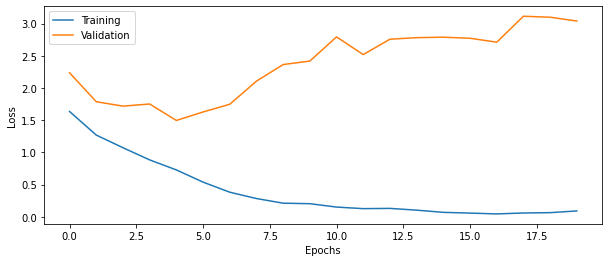

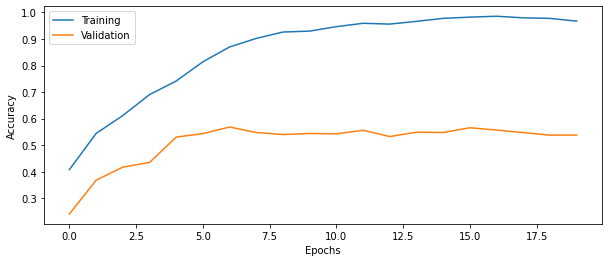

In [0]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [0]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model3 = build_CNN(input_shape=input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history3 = model3.fit(x=Xtrain, y=Ytrain, batch_size=batch_size, epochs=epochs,verbose=1, validation_data=(Xval,Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 245us/step - loss: 1.7489 - accuracy: 0.3633 - val_loss: 1.8514 - val_accuracy: 0.3476
Epoch 2/20
7500/7500 [==============================] - 1s 137us/step - loss: 1.4027 - accuracy: 0.4869 - val_loss: 1.6877 - val_accuracy: 0.3980
Epoch 3/20
7500/7500 [==============================] - 1s 133us/step - loss: 1.2186 - accuracy: 0.5565 - val_loss: 1.8199 - val_accuracy: 0.4044
Epoch 4/20
7500/7500 [==============================] - 1s 137us/step - loss: 1.0330 - accuracy: 0.6267 - val_loss: 1.2852 - val_accuracy: 0.5448
Epoch 5/20
7500/7500 [==============================] - 1s 134us/step - loss: 0.8917 - accuracy: 0.6829 - val_loss: 1.4069 - val_accuracy: 0.5356
Epoch 6/20
7500/7500 [==============================] - 1s 133us/step - loss: 0.7605 - accuracy: 0.7329 - val_loss: 1.3664 - val_accuracy: 0.5652
Epoch 7/20
7500/7500 [==============================] - 1s 135us/step - loss

In [0]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest,Ytest,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 46us/step
Test loss: 2.5501
Test accuracy: 0.5855


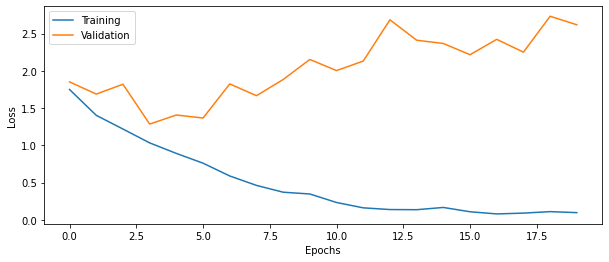

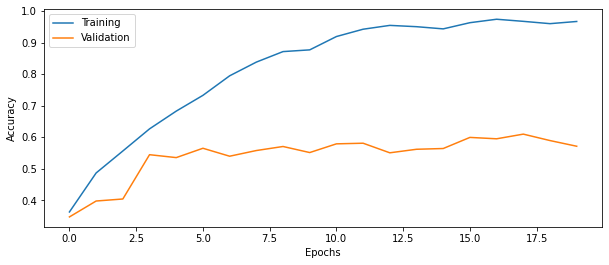

In [0]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

Answer: Trainable params: 124,180 , Conv2D network contains most of the parameters

Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output?

Answer: Input: Number of filters to applied to the model, Output: Tensor Convolved images. The dimensions of input and output are 4D

Answer: Input is the number of filters and output is the activation map which contains the  

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

Answer: Yes

Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?

Answer: Output will have 128 channels which is equal to the number of filters

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?

Answer: Since the Conv2D is performing a 3D convolution to combine all the channels in input tensor, it is not equal to the no. of filter times no. of coefficeints.  

Question 19: How does MaxPooling help in reducing the number of parameters to train?

Answer: Maxpooling takes the maximum value of the filter responses in each (2,2) neighbourhood. This helps in reducing the number of dimensions to a factor 4. 

[Previous answer(for ref.):Maxpooling only takes tha maximum value of the filter responses. This will help us to capture all the details without loosing any information with reduced dimansionality. 

In [0]:
# Print network architecture

model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)         

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout?

Answer: Using Droupout, the accuracy increased from around 57% to 61%

Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?

Answer: Early stopping, Data Agumentation. Apply L2 regularizer in Dense layer

## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [0]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape[1:]

# Build model
model4 = build_CNN(input_shape=input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=True, learning_rate=0.01)

# Train the model  using training data and validation data
history4 = model4.fit(x=Xtrain, y=Ytrain, batch_size=batch_size, epochs=epochs,verbose=1, validation_data=(Xval,Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 242us/step - loss: 1.8811 - accuracy: 0.3112 - val_loss: 1.8107 - val_accuracy: 0.3384
Epoch 2/20
7500/7500 [==============================] - 1s 134us/step - loss: 1.5881 - accuracy: 0.4072 - val_loss: 1.9367 - val_accuracy: 0.2824
Epoch 3/20
7500/7500 [==============================] - 1s 133us/step - loss: 1.4831 - accuracy: 0.4420 - val_loss: 1.6726 - val_accuracy: 0.3660
Epoch 4/20
7500/7500 [==============================] - 1s 134us/step - loss: 1.3794 - accuracy: 0.4929 - val_loss: 1.4436 - val_accuracy: 0.4800
Epoch 5/20
7500/7500 [==============================] - 1s 134us/step - loss: 1.2544 - accuracy: 0.5460 - val_loss: 1.3259 - val_accuracy: 0.5240
Epoch 6/20
7500/7500 [==============================] - 1s 135us/step - loss: 1.1904 - accuracy: 0.5645 - val_loss: 1.3303 - val_accuracy: 0.5504
Epoch 7/20
7500/7500 [==============================] - 1s 133us/step - loss

In [0]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest,Ytest,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 52us/step
Test loss: 1.6414
Test accuracy: 0.6115


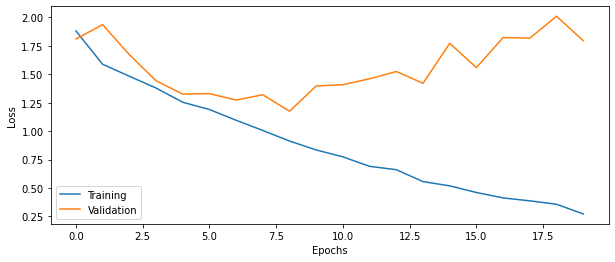

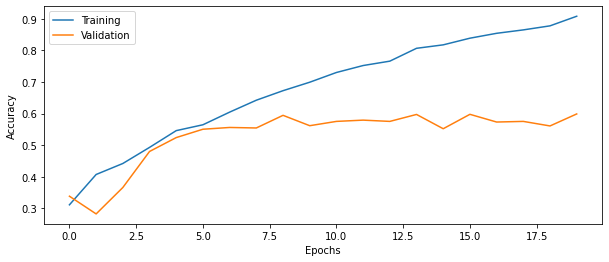

In [0]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration?

Answer: Best configuration is shown here.

## Your best config

In [0]:
# Setup some training parameters

# Build model
model5 = build_CNN(input_shape=input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=2, n_nodes=80, use_dropout=True, learning_rate=0.01)

# Train the model  using training data and validation data
history5 =  model5.fit(x=Xtrain, y=Ytrain, batch_size=batch_size, epochs=epochs,verbose=1, validation_data=(Xval,Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 274us/step - loss: 2.1328 - accuracy: 0.2281 - val_loss: 3.1133 - val_accuracy: 0.2000
Epoch 2/20
7500/7500 [==============================] - 1s 145us/step - loss: 1.7566 - accuracy: 0.3353 - val_loss: 1.7626 - val_accuracy: 0.3592
Epoch 3/20
7500/7500 [==============================] - 1s 147us/step - loss: 1.6331 - accuracy: 0.3816 - val_loss: 1.7335 - val_accuracy: 0.3800
Epoch 4/20
7500/7500 [==============================] - 1s 147us/step - loss: 1.5405 - accuracy: 0.4221 - val_loss: 1.5646 - val_accuracy: 0.4344
Epoch 5/20
7500/7500 [==============================] - 1s 145us/step - loss: 1.4478 - accuracy: 0.4701 - val_loss: 1.4089 - val_accuracy: 0.5016
Epoch 6/20
7500/7500 [==============================] - 1s 144us/step - loss: 1.3299 - accuracy: 0.5097 - val_loss: 1.5077 - val_accuracy: 0.4788
Epoch 7/20
7500/7500 [==============================] - 1s 144us/step - loss

In [0]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest,Ytest,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 49us/step
Test loss: 1.5589
Test accuracy: 0.6055


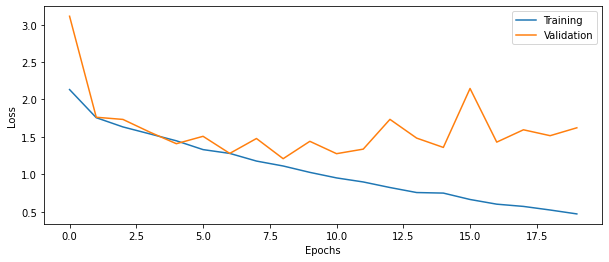

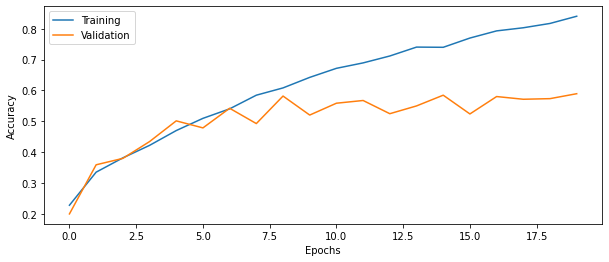

In [0]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

Answer: The test accuracy of rotated images is around 22% which is lower than the test accuray of test images without rotation. The rotated images are basically like a new training image for the model. The model we have trained don't have a class of rotated images and a label for it. Hence, it is not recognizing them well. This is leading to reduced accuracy. 

In [0]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

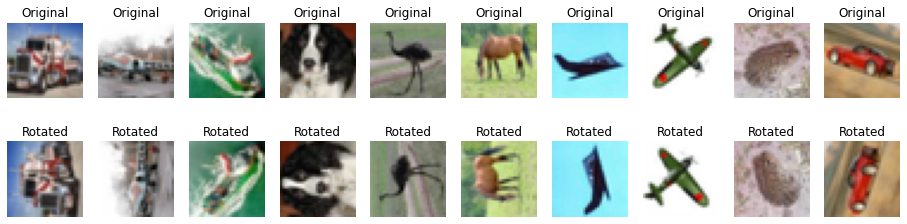

In [0]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [0]:
# Evaluate the trained model on rotated test set
score = model4.evaluate(Xtest_rotated,Ytest,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 70us/step
Test loss: 4.8101
Test accuracy: 0.2260


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/

In [0]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [0]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(validation_split=0.2, rotation_range=30, horizontal_flip=True, vertical_flip=True)


# Setup a flow for training data, assume that we can fit all images into CPU memory
train_datagen = datagen.flow(Xtrain,Ytrain, subset='training')
# Setup a flow for validation data, assume that we can fit all images into CPU memory
valid_datagen=datagen.flow(Xval,Yval,subset='validation')

## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

Answer: If our data is too big to fit in the memory, we use Generator (image_dataset_from_directory) which can generate dataset from image files. The dataset can then be used to train the model. The major disadvantage would be, the speed will depend on how fast the hard drive is. 

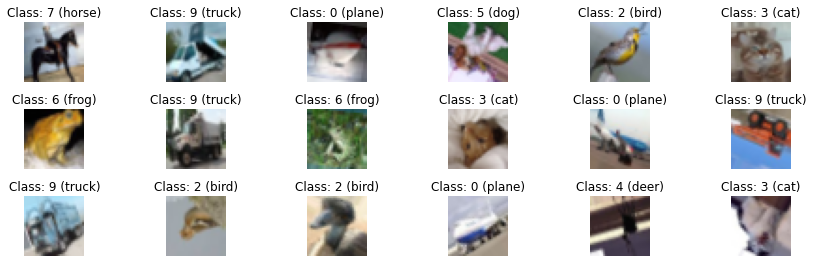

In [0]:
# Plot some augmented images
plot_datagen = datagen.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/models/model/ for how to use model.fit_generator instead of model.fit for training

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

Answer: The training accuracy increased from around 22%(without augmentation) to 55%(with augmentation). This happend as the model is now trained along with augmented images and it able to classify the new test augmented images better. 

Question 26: What other types of image augmentation can be applied, compared to what we use here?

Answer: Other image augmentations that can be applied are: 
Cropping, color space transformations, injecting noise, multiple rotations. 

In [0]:
# Setup some training parameters
batch_size = 100
epochs = 200
input_shape = Xtrain.shape[1:]

# Build model (your best config)
model6 = build_CNN(input_shape=input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=2, n_nodes=80, use_dropout=True, learning_rate=0.01)

validation_split=0.2
steps_per_epoch = len(Xtrain)*(1-validation_split)/batch_size
validation_steps = len(Xtrain)*validation_split/batch_size
# Train the model using on the fly augmentation
history6 = model6.fit_generator(train_datagen,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,epochs=epochs, validation_data=valid_datagen)

Epoch 1/200
80/80 [==============================] - 3s 37ms/step - loss: 2.4561 - accuracy: 0.1562 - val_loss: 1.9702 - val_accuracy: 0.2134
Epoch 2/200
80/80 [==============================] - 2s 23ms/step - loss: 2.1134 - accuracy: 0.2051 - val_loss: 2.5506 - val_accuracy: 0.1720
Epoch 3/200
80/80 [==============================] - 2s 23ms/step - loss: 2.0374 - accuracy: 0.2105 - val_loss: 2.0547 - val_accuracy: 0.1783
Epoch 4/200
80/80 [==============================] - 2s 24ms/step - loss: 2.0180 - accuracy: 0.2180 - val_loss: 1.8663 - val_accuracy: 0.2321
Epoch 5/200
80/80 [==============================] - 2s 25ms/step - loss: 1.9449 - accuracy: 0.2480 - val_loss: 1.9589 - val_accuracy: 0.2516
Epoch 6/200
80/80 [==============================] - 2s 24ms/step - loss: 1.9564 - accuracy: 0.2438 - val_loss: 1.7403 - val_accuracy: 0.3201
Epoch 7/200
80/80 [==============================] - 2s 23ms/step - loss: 1.8842 - accuracy: 0.2777 - val_loss: 1.7136 - val_accuracy: 0.3153
Epoch 

In [0]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.2206
Test accuracy: 0.5505
Test loss: 2.2194
Test accuracy: 0.2880


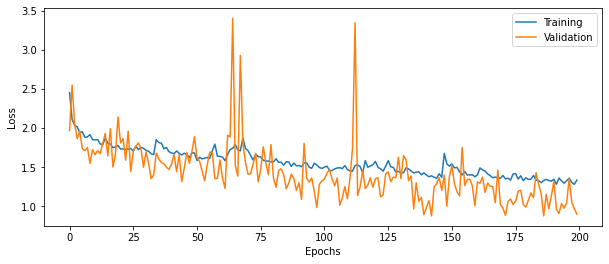

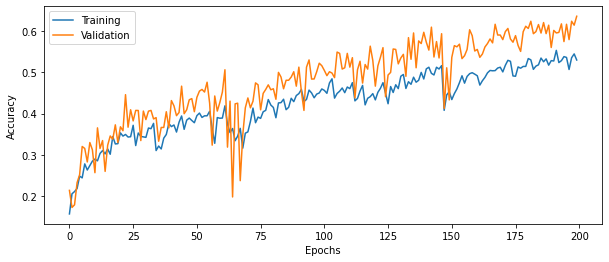

In [0]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly

In [0]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest,axis=1)

miss = np.flatnonzero(y_correct != y_pred)

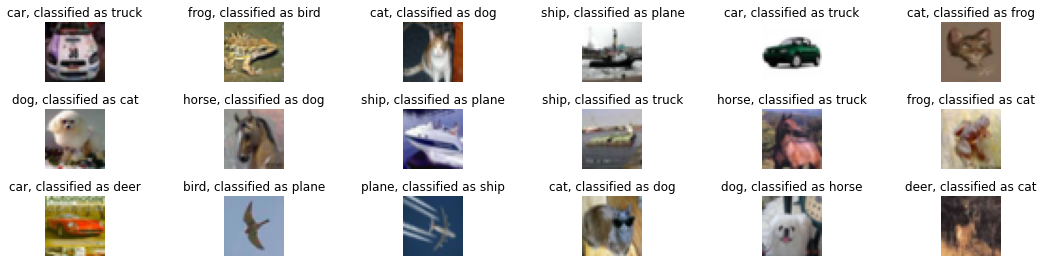

In [0]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

Answer: It is not possible to directly apply this model on images of other size.  The reason is, the size of the image tells the number of dimensions that image possess. If the size is changed, we are basically increasing or decreasing the dimensions of our image training points which will have it's own classification based on the dimensions.So, the layers within CNN will not be trained to have a different structure. 

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

Answer: The most effective way to design a CNN that can classify images multiple sizes would be to add a pre processing layer where we resize the image to a default size and then train the CNN. 

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database. Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have? 

Answer: It has more than 50 Conv layers

Question 30: How many trainable parameters does the ResNet50 network have? 

ANswer: 25,583,592 Trainable params

Question 31: What is the size of the images that ResNet50 expects as input?

Answer: The required image size for ResNet50 is (224,224)

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.

Answer: When second derivative is performed, we basically are creating a Hessian matrix. With 25 million parameters, we will be creating 25 million by 25 million matrix which is too large and takes a lot of time and memory to compute.

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine. Are the predictions correct? How certain is the network of each image class?

Answers: The dataset has greater classification of images. So, all the 5 predictions are correct. The predicted results comes with the probability which is high for the correct class in all the cases. 

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/applications/#resnet

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


In [0]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
from PIL import Image as pil_image
from PIL import ImageEnhance

resnet = ResNet50(weights="imagenet")

# model summary
resnet.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
#elephant
img_path = '/elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])


Predicted: [('n02504458', 'African_elephant', 0.8211695), ('n01871265', 'tusker', 0.10016799), ('n02504013', 'Indian_elephant', 0.033397976)]


In [0]:
#cat
img_path = '/cat-blue-eyes.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02123045', 'tabby', 0.34345105), ('n02124075', 'Egyptian_cat', 0.2972358), ('n02123159', 'tiger_cat', 0.27644667)]


In [0]:
#bird
img_path = '/bird.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n01592084', 'chickadee', 0.99972814), ('n01601694', 'water_ouzel', 0.00010021058), ('n01560419', 'bulbul', 7.819144e-05)]


In [0]:
#flower
img_path = '/flower.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n11939491', 'daisy', 0.9110343), ('n02206856', 'bee', 0.06255821), ('n03930313', 'picket_fence', 0.0054772757)]


In [0]:
# dog
img_path = '/dog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02099601', 'golden_retriever', 0.93378365), ('n02099712', 'Labrador_retriever', 0.048914585), ('n02101556', 'clumber', 0.0054556215)]


In [0]:
# gray scale image
img_path = '/gray_scale_dog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = resnet.predict(x)

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02099712', 'Labrador_retriever', 0.42196256), ('n02099849', 'Chesapeake_Bay_retriever', 0.1388767), ('n02092339', 'Weimaraner', 0.11458077)]
